# Amplitude Crosscorrelation Example

In [9]:
#Import Modules
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt, xcorr

# Import NeuroDSP 
from neurodsp import sim
from neurodsp.filt import filter_signal
from neurodsp.sim import sim_combined
from neurodsp.utils import create_times
from neurodsp.timefrequency import amp_by_time
from neurodsp.plts.time_series import plot_time_series

## Simulate periodic signal

In [284]:
# set the random seed, for consistency simulating data
sim.set_random_seed(0)

# define length and sample freq
n_seconds = 20
fs = 1000

# create time vector
times = create_times(n_seconds, fs)

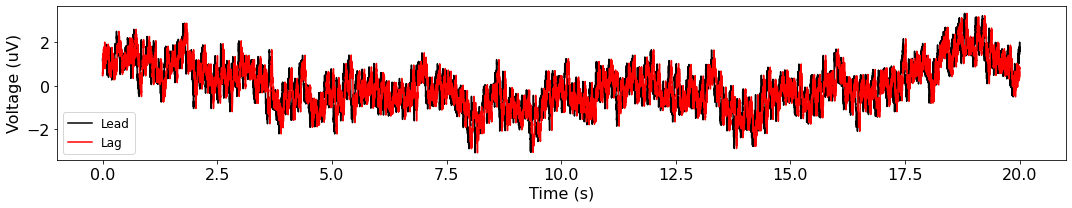

In [287]:
# desired lag
lag_in_ms = 50
lag_in_samples = round(lag_in_ms*(fs/1000))

# define simulated oscillation w/noise
components = {'sim_powerlaw' : {'exponent' : -1.4},
              'sim_oscillation' : {'freq' : 7.5}}
variances = [2, .2]

# simulate oscillation w/noise
lead_sig = sim_combined(n_seconds, fs, components, variances)
lag_sig = np.roll(lead_sig, lag_in_samples) #circular shift 50ms

# plot
plot_time_series(times, [lead_sig, lag_sig], ['Lead', 'Lag'])

## Compute amplitude crosscorrelation

In [265]:
def amp_xcorr(sig1, sig2, fs, f_range, plot=True):

    """Filters two signals between a specified freq band,
    calculates the crosscorrelation of the amplitude envelope of the
    filter signals, and returns the max crosscorrelation and corresponding lag.
    
    Parameters
    ----------
    sig1 : 1d array
        local field potential 1 
    sig2 : 1d array
        local field potential 2
    fs : float
        sampling frequency in Hz 
    f_range : tuple float
        filter range in Hz as [low, high]
        
    Returns
    -------
    max_crosscorr : float
        maximum crosscorrelation of the two signals
    max_crosscorr_lag : float
        lag between the signals at the max crosscorrelation
        
    Notes
    -----
    This code was adapted from the amp_crosscorr() Matlab function written
    by Adhikari et al. [1]. This uses both the xcorr() python function to compute
    crosscorrelations written by github user colizoli [2] and amp_by_time() function
    written by Cole et al. [3]. 
    
    References
    ----------
    
    [1] Adhikari, A., Sigurdsson, T., Topiwala, M.A. and Gordon, J.A. 2010.  
            Journal of Neuroscience Methods 191(2), pp. 191–200. 
            DIO: 10.1016/j.jneumeth.2010.06.019
    [2] https://github.com/colizoli/xcorr_python
    [3] Cole, S., Donoghue, T., Gao, R., & Voytek, B. (2019). NeuroDSP: A package for
            neural digital signal processing. Journal of Open Source Software, 4(36), 1272.
            DOI: 10.21105/joss.01272
    """
        
    # Get bandpass amplitude via hilbert transform
    amp1 = amp_by_time(sig1, fs, f_range, remove_edges=False)
    amp1 = amp1 - np.mean(amp1)
    amp2 = amp_by_time(sig2, fs, f_range, remove_edges=False)
    amp2 = amp2 - np.mean(amp2)

    # compute cross-correlation, convert lag to ms
    lags, crosscorr = xcorr(amp1, amp2, maxlags=round(fs/10))
    lags = (lags/fs)*1000
    
    # get max xcorr and lag
    g = crosscorr.argmax()
    max_crosscorr = crosscorr[g]
    max_crosscorr_lag = lags[g]

    # plot
    if plot:
        plt.plot(lags, crosscorr)
        plt.scatter(lags[g], crosscorr[g], s=50, color='r',marker='*')
        plt.axvline(x=0, color= 'k', linestyle='--')
        plt.xlim([-100, 100])
        plt.xlabel('Lag (ms)')
        plt.ylabel('Cross-correlation')
    
    return max_crosscorr, max_crosscorr_lag

def xcorr(x, y, normed=True, detrend=False, maxlags=10):
    # Cross correlation of two signals of equal length
    # Returns the coefficients when normed=True
    # Returns inner products when normed=False
    # Usage: lags, c = xcorr(x,y,maxlags=len(x)-1)
    # Optional detrending e.g. mlab.detrend_mean
    #
    # I found this function written by colizoli on GitHub
    # and it's exactly what I needed. It's designed to 
    # work like Matlab's xcorr() function. 
    #
    # https://github.com/colizoli/xcorr_python

    Nx = len(x)
    if Nx != len(y):
        raise ValueError('x and y must be equal length')
    
    if detrend:
        import matplotlib.mlab as mlab
        x = mlab.detrend_mean(np.asarray(x)) # can set your preferences here
        y = mlab.detrend_mean(np.asarray(y))
    
    c = np.correlate(x, y, mode='full')

    if normed:
        n = np.sqrt(np.dot(x, x) * np.dot(y, y)) # this is the transformation function
        c = np.true_divide(c,n)

    if maxlags is None:
        maxlags = Nx - 1

    if maxlags >= Nx or maxlags < 1:
        raise ValueError('maglags must be None or strictly '
                         'positive < %d' % Nx)

    lags = np.arange(-maxlags, maxlags + 1)
    c = c[Nx - 1 - maxlags:Nx + maxlags]
    return lags, c

0.9889480029653722 -51.0


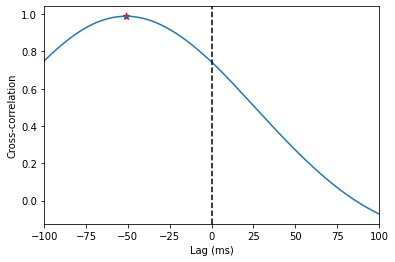

In [288]:
# computer amplitude crosscorrelation
max_xcorr, max_lag = amp_xcorr(lead_sig, lag_sig, fs, [4, 12])

print(max_xcorr, max_lag)

## Bootstrapping for significance

In [308]:
def bootstrap_xcorr(sig1, sig2, fs, f_range, low_shift=5, high_shift=10, n_shifts=1000):


    # generate random array of seconds to shift
    shift_seconds = rand_neg_uni(low_shift, high_shift, n_shifts)

    # Get bandpass amplitude via hilbert transform
    amp1 = amp_by_time(sig1, fs, f_range, remove_edges=False)
    amp1 = amp1 - np.mean(amp1)
    amp2 = amp_by_time(sig2, fs, f_range, remove_edges=False)
    amp2 = amp2 - np.mean(amp2)
    
    # computer xcorr for every shift
    bs_dist = np.zeros(rand_shift.shape)
    for n in range(0,len(shift_seconds)):
        
        # shift signal
        shift_samples = int(round(shift_seconds[n]*fs))  # seconds to samples
        amp2_shifted = np.roll(amp2, shift_samples)

        # compute cross-correlation, convert lag to ms
        lags, crosscorr = xcorr(amp1, amp2_shifted, maxlags=round(fs/10))
        lags = (lags/fs)*1000

        # get max xcorr
        bs_dist[n] = crosscorr.max()
        
    return bs_dist

def rand_neg_uni(low_int, high_int, n_rand):
    """
    Randomly generates positive and negative uniformly generated 
    numbers within a defined limit.
    """
    
    # uniformly generated random numbers
    rand_uni = np.random.uniform(low_int, high_int ,n_rand)

    # logic for random negatives
    a = np.random.randint(0,2,n_rand)
    rand_logic = (a == 1)

    # negative uniform
    for n in range(0,len(rand_uni)):
        if rand_logic[n]:
            rand_uni[n] = np.negative(rand_uni[n])
            
    return rand_uni

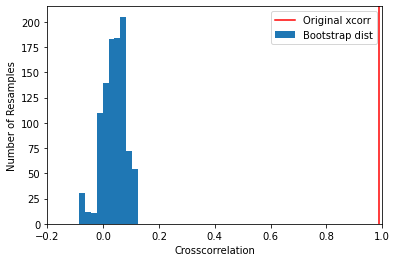

In [313]:
# compute bootstrap
bs_dist = bootstrap_xcorr(lead_sig, lag_sig, fs, f_range)
 
# plot distribution with orginial xcorr
plt.hist(bs_dist)
plt.xlim([-.2, 1])
plt.axvline(x=max_xcorr, color= 'r', linestyle='-')
plt.xlabel('Crosscorrelation')
plt.ylabel('Number of Resamples')
plt.legend(['Original xcorr', 'Bootstrap dist'])